In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.signal import filtfilt
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras

from keras.layers.core import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Embedding

# Load Data

In [3]:
df_word=pd.read_csv("/content/drive/MyDrive/Programs/final_project/input/classes_V01.txt",sep="\t",header=None)

df_word.columns=['name','repetition','target','category']

df_word.head(2)

,name,repetition,target,category
0,"domestic cat, house cat, Felis domesticus, Fel...",24,n02121808,Mammals
1,"rock python, rock snake, Python sebae",29,n01744401,Reptile


In [4]:
#read complete merged file
df=pd.read_csv("/content/drive/MyDrive/Programs/final_project/output/merged.csv")
df.shape

(70060, 450)

In [5]:
df=df.iloc[:,1:]    #all data
#df=df.iloc[:30000,1:]    #sample data (should be multiple of 5)
df.head(6)

,global_session_id,number_of_sessions,image_id,image_category,channels,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,...,t_405,t_406,t_407,t_408,t_409,t_410,t_411,t_412,t_413,t_414,t_415,t_416,t_417,t_418,t_419,t_420,t_421,t_422,t_423,t_424,t_425,t_426,t_427,t_428,t_429,t_430,t_431,t_432,t_433,t_434,t_435,t_436,t_437,t_438,t_439,t_440,t_441,t_442,t_443,t_444
0,2602,1,4823,n02077923,AF3,4320.000000,4332.307692,4334.871795,4342.564103,4333.333333,4313.333333,4318.974359,4349.743590,4358.974359,4335.384615,4321.025641,4333.333333,4345.641026,4334.358974,4321.025641,4320.000000,4321.538462,4320.000000,4311.794872,4309.230769,4311.282051,4301.025641,4288.205128,4291.794872,4296.923077,4290.769231,4303.076923,4337.435897,4334.358974,4298.974359,4292.307692,4305.128205,4305.641026,4305.641026,4303.589744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2602,1,4823,n02077923,AF4,4294.871795,4305.128205,4298.974359,4307.179487,4312.307692,4284.102564,4274.871795,4314.358974,4330.769231,4324.615385,4311.282051,4275.384615,4284.615385,4322.564103,4318.461538,4285.641026,4272.820513,4307.692308,4353.333333,4341.538462,4307.179487,4307.692308,4307.692308,4304.615385,4321.538462,4312.307692,4292.307692,4298.461538,4285.641026,4278.461538,4311.282051,4318.974359,4297.435897,4301.025641,4321.538462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2602,1,4823,n02077923,T7,4187.692308,4200.000000,4208.717949,4199.487179,4199.487179,4208.205128,4210.769231,4228.205128,4258.974359,4257.948718,4232.820513,4235.384615,4251.282051,4246.666667,4245.128205,4245.641026,4237.948718,4237.948718,4237.435897,4229.743590,4237.435897,4245.641026,4230.769231,4222.051282,4230.256410,4232.307692,4227.179487,4231.282051,4244.102564,4250.769231,4241.538462,4231.794872,4237.435897,4244.615385,4244.615385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2602,1,4823,n02077923,T8,4203.076923,4224.615385,4249.743590,4231.794872,4190.769231,4186.666667,4208.717949,4223.589744,4226.153846,4229.230769,4233.846154,4222.564103,4210.256410,4215.384615,4217.948718,4202.051282,4188.717949,4202.564103,4215.897436,4219.487179,4226.666667,4214.358974,4183.589744,4184.102564,4221.538462,4242.564103,4226.153846,4217.948718,4225.128205,4208.717949,4185.128205,4206.153846,4228.717949,4204.102564,4182.051282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2602,1,4823,n02077923,Pz,4145.128205,4138.461538,4145.128205,4142.051282,4132.307692,4134.358974,4137.948718,4146.153846,4155.384615,4149.743590,4147.692308,4152.820513,4145.128205,4138.461538,4146.153846,4144.615385,4140.512821,4152.820513,4168.717949,4175.384615,4167.692308,4150.256410,4147.179487,4157.948718,4148.717949,4130.256410,4138.461538,4154.871795,4136.410256,4113.846154,4135.897436,4161.538462,4154.358974,4146.153846,4150.769231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2601,1,168,n02089078,AF3,4279.487179,4279.487179,4280.512821,4297.435897,4315.384615,4299.487179,4278.974359,4292.307692,4302.051282,4299.487179,4297.948718,4289.230769,4289.230769,4297.948718,4297.435897,4293.846154,4282.051282,4261.025641,4275.897436,4299.487179,4286.666667,4275.384615,4271.282051,4282.051282,4297.435897,4280.512821,4267.692308,4277.948718,4284.102564,4289.230769,4291.794872,4278.974359,4274.358974,4281.025641,4282.564103,...,NaN,NaN,NaN

In [6]:
df.shape #check shape of all data

(70060, 449)

In [7]:
df.isnull().sum()  #check if there are any NA values

global_session_id         0
number_of_sessions        0
image_id                  0
image_category            0
channels                  0
                      ...  
t_440                 70050
t_441                 70055
t_442                 70055
t_443                 70055
t_444                 70055
Length: 449, dtype: int64

In [8]:
#Drop Columns which have more than 90% NAs 
df.dropna(axis=1, thresh=int(0.1 * df.shape[0]),inplace=True)
df.shape

(70060, 397)

In [9]:
#df.fillna(0, inplace=True)        #replace NaN with 0  
df=df.ffill(axis = 1)

In [10]:
df.isnull().sum()                   #verify there are no null values

global_session_id     0
number_of_sessions    0
image_id              0
image_category        0
channels              0
                     ..
t_388                 0
t_389                 0
t_390                 0
t_391                 0
t_392                 0
Length: 397, dtype: int64

In [11]:
df_main=df.drop(['global_session_id',	'number_of_sessions',	'image_id',	'channels'],axis=1)

df_main.head(3)

,image_category,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,...,t_353,t_354,t_355,t_356,t_357,t_358,t_359,t_360,t_361,t_362,t_363,t_364,t_365,t_366,t_367,t_368,t_369,t_370,t_371,t_372,t_373,t_374,t_375,t_376,t_377,t_378,t_379,t_380,t_381,t_382,t_383,t_384,t_385,t_386,t_387,t_388,t_389,t_390,t_391,t_392
0,n02077923,4320,4332.31,4334.87,4342.56,4333.33,4313.33,4318.97,4349.74,4358.97,4335.38,4321.03,4333.33,4345.64,4334.36,4321.03,4320,4321.54,4320,4311.79,4309.23,4311.28,4301.03,4288.21,4291.79,4296.92,4290.77,4303.08,4337.44,4334.36,4298.97,4292.31,4305.13,4305.64,4305.64,4303.59,4286.15,4273.33,4274.87,4277.95,...,4276.41,4277.95,4275.38,4258.97,4261.03,4271.79,4266.15,4265.64,4267.18,4260,4262.05,4265.64,4257.95,4254.87,4267.69,4286.15,4284.62,4265.13,4256.41,4261.03,4265.64,4261.03,4239.49,4213.85,4229.23,4265.13,4263.59,4250.26,4266.67,4275.38,4250.26,4233.85,4235.9,4216.92,4192.82,4200,4224.62,4240.51,4233.85,4210.77
1,n02077923,4294.87,4305.13,4298.97,4307.18,4312.31,4284.1,4274.87,4314.36,4330.77,4324.62,4311.28,4275.38,4284.62,4322.56,4318.46,4285.64,4272.82,4307.69,4353.33,4341.54,4307.18,4307.69,4307.69,4304.62,4321.54,4312.31,4292.31,4298.46,4285.64,4278.46,4311.28,4318.97,4297.44,4301.03,4321.54,4325.13,4320,4294.87,4271.28,...,4238.46,4242.56,4290.77,4284.62,4238.97,4250.77,4297.95,4325.64,4326.67,4294.87,4265.13,4254.36,4251.28,4272.31,4273.85,4240,4239.49,4269.23,4267.69,4254.87,4265.13,4272.82,4254.36,4223.59,4254.36,4302.56,4257.95,4215.38,4256.41,4264.1,4211.79,4210.26,4243.59,4232.82,4211.28,4222.05,4228.72,4213.85,4220,4246.67
2,n02077923,4187.69,4200,4208.72,4199.49,4199.49,4208.21,4210.77,4228.21,4258.97,4257.95,4232.82,4235.38,4251.28,4246.67,4245.13,4245.64,4237.95,4237.95,4237.44,4229.74,4237.44,4245.64,4230.77,4222.05,4230.26,4232.31,4227.18,4231.28,4244.1,4250.77,4241.54,4231.79,4237.44,4244.62,4244.62,4244.1,4233.85,4218.46,4212.82,...,4258.97,4237.95,4240.51,4254.36,4254.36,4254.87,4262.56,4254.87,4237.95,4247.69,4271.28,4264.62,4248.72,4258.46,4273.85,4271.79,4258.97,4250.77,4253.85,4265.13,4264.1,4247.18,4241.54,4237.44,4238.97,4268.21,4289.23,4271.79,4256.92,4273.85,4267.18,4230.26,4221.54,4234.87,4234.87,4228.21,4228.21,4232.31,4232.82,4229.74


In [12]:
df_main.shape               #check shape after dropping other columns

(70060, 393)

In [13]:
df_main.shape[0]/5

14012.0

In [14]:
df_main.iloc[1,1:]      #view time stamps

t_1      4294.87
t_2      4305.13
t_3      4298.97
t_4      4307.18
t_5      4312.31
          ...   
t_388    4222.05
t_389    4228.72
t_390    4213.85
t_391       4220
t_392    4246.67
Name: 1, Length: 392, dtype: object

# Data Preparation
1. Merging subcategory
2. Applying filters
3. Separating  X, y

In [15]:
#apply filters to data

def apply_bp_filter(signals,filter_type='bandpass'):

  fs= 128.0              # sample rate, Hz
  lowcut = 20.0
  highcut = 50.0

  nyq = 0.5*fs              #The Nyquist frequency is half the sampling rate
  low = lowcut / nyq
  high = highcut / nyq

  order = 2 

  if filter_type=='low':
    b, a = scipy.signal.butter(order, low, btype='low', analog=False)
  elif filter_type=='high':
    b, a = scipy.signal.butter(order, high, btype='high', analog=False)
  else:
    b,a = scipy.signal.butter(order,(low,high),'bandpass',analog=False)

  signals = scipy.signal.filtfilt(b,a,signals.T,axis=0)
  
  return pd.Series(signals.transpose())

In [16]:
#visual representation of signals  #pass single row at a time

def display_signal(single_row):

    #print(type(single_row))
    plt.figure(figsize=(10, 1))

    #print(type(single_row))

    plt.plot(range(len(single_row)), single_row)
  
    plt.title("Signal")
    plt.ylabel('frequency')
    plt.xlabel('time')
    #plt.legend()
    plt.show()
    print("\n")

In [17]:
# replace category with sub category

def find_and_replace(word):
  target_dict={"Animals":["Mammals","Bird","Reptile","Fish","amphibian","Asteroidea","Arthropods","arachnids","Insect"],
             "Tool":["Tool","MusicInstrument","MedicalInstrument","Stationary"],
             "Fashion":["Clothe","Cosmetics"],
             "Home_Appliances":["KitchenWare","Electronics","Furniture"],
             "Transport":["Vehicle","shipboat"],
             "Sports":["Sports"],
             "Place":["Road","Place","Airport","Event"],
             "Food":["Fruit","Food","Vegitable"],
             "Human":["Human"]            
             }
  list_list=[]
  for i in target_dict.values():
    list_list.append(i)
  for n in range(len(list_list)):
     if word in list_list[n]:
      key_index=n
  keys_list = list(target_dict)
  key = keys_list[key_index]
  return key

In [18]:
#Data preparation : filtering, creating batches of 5 signals

def prepare_data(data_frame,num_channels,unit_test=False):

  signals_list=[]
  signals_cat=[]
  n=num_channels #number ofchannels 

  for i in range(0,data_frame.shape[0],num_channels):
    
    #print("i=",i, "\n",df_main[i:i+n])                 #info

    channels_list=[]

    df_batch=df_main[i:i+n]

    class_label=df_batch.loc[i][0]
    

    sub_class_label=df_word.loc[df_word['target']==class_label,'category'].to_list()[0]

    sub_class_label=find_and_replace(sub_class_label)      #sub_class level 2

    
    

    #print(df_batch.loc[i][0])                          #info
    #print(df_batch.iloc[:,1:])                         #info

    for i, row in df_batch.iloc[:,1:].iterrows():

        if unit_test: display_signal(row)                            #display signal before filter

        row=apply_bp_filter(row)                        #apply bandpass filter
        
        row=apply_bp_filter(row,'low')                  #apply low pass filter

        row=apply_bp_filter(row,'high')

        if unit_test: display_signal(row)                            #display signal after filter

        row_ls = row.values.tolist()                    # create a list of values from dataframe row

        #print("lenght= ",len(row_ls))                  #info
        #print(row_ls)                                  #info
        
        signals_list.append(row_ls)                    #append row list to signals list
        signals_cat.append(sub_class_label)
    
    #signals_list.extend(channels_list) 

  return signals_list,signals_cat

In [19]:
#get sample data unit test : set of five channels 
df_sample=df_main.iloc[:10,:].copy()
df_sample

,image_category,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,...,t_353,t_354,t_355,t_356,t_357,t_358,t_359,t_360,t_361,t_362,t_363,t_364,t_365,t_366,t_367,t_368,t_369,t_370,t_371,t_372,t_373,t_374,t_375,t_376,t_377,t_378,t_379,t_380,t_381,t_382,t_383,t_384,t_385,t_386,t_387,t_388,t_389,t_390,t_391,t_392
0,n02077923,4320,4332.31,4334.87,4342.56,4333.33,4313.33,4318.97,4349.74,4358.97,4335.38,4321.03,4333.33,4345.64,4334.36,4321.03,4320,4321.54,4320,4311.79,4309.23,4311.28,4301.03,4288.21,4291.79,4296.92,4290.77,4303.08,4337.44,4334.36,4298.97,4292.31,4305.13,4305.64,4305.64,4303.59,4286.15,4273.33,4274.87,4277.95,...,4276.41,4277.95,4275.38,4258.97,4261.03,4271.79,4266.15,4265.64,4267.18,4260,4262.05,4265.64,4257.95,4254.87,4267.69,4286.15,4284.62,4265.13,4256.41,4261.03,4265.64,4261.03,4239.49,4213.85,4229.23,4265.13,4263.59,4250.26,4266.67,4275.38,4250.26,4233.85,4235.9,4216.92,4192.82,4200,4224.62,4240.51,4233.85,4210.77
1,n02077923,4294.87,4305.13,4298.97,4307.18,4312.31,4284.1,4274.87,4314.36,4330.77,4324.62,4311.28,4275.38,4284.62,4322.56,4318.46,4285.64,4272.82,4307.69,4353.33,4341.54,4307.18,4307.69,4307.69,4304.62,4321.54,4312.31,4292.31,4298.46,4285.64,4278.46,4311.28,4318.97,4297.44,4301.03,4321.54,4325.13,4320,4294.87,4271.28,...,4238.46,4242.56,4290.77,4284.62,4238.97,4250.77,4297.95,4325.64,4326.67,4294.87,4265.13,4254.36,4251.28,4272.31,4273.85,4240,4239.49,4269.23,4267.69,4254.87,4265.13,4272.82,4254.36,4223.59,4254.36,4302.56,4257.95,4215.38,4256.41,4264.1,4211.79,4210.26,4243.59,4232.82,4211.28,4222.05,4228.72,4213.85,4220,4246.67
2,n02077923,4187.69,4200,4208.72,4199.49,4199.49,4208.21,4210.77,4228.21,4258.97,4257.95,4232.82,4235.38,4251.28,4246.67,4245.13,4245.64,4237.95,4237.95,4237.44,4229.74,4237.44,4245.64,4230.77,4222.05,4230.26,4232.31,4227.18,4231.28,4244.1,4250.77,4241.54,4231.79,4237.44,4244.62,4244.62,4244.1,4233.85,4218.46,4212.82,...,4258.97,4237.95,4240.51,4254.36,4254.36,4254.87,4262.56,4254.87,4237.95,4247.69,4271.28,4264.62,4248.72,4258.46,4273.85,4271.79,4258.97,4250.77,4253.85,4265.13,4264.1,4247.18,4241.54,4237.44,4238.97,4268.21,4289.23,4271.79,4256.92,4273.85,4267.18,4230.26,4221.54,4234.87,4234.87,4228.21,4228.21,4232.31,4232.82,4229.74
3,n02077923,4203.08,4224.62,4249.74,4231.79,4190.77,4186.67,4208.72,4223.59,4226.15,4229.23,4233.85,4222.56,4210.26,4215.38,4217.95,4202.05,4188.72,4202.56,4215.9,4219.49,4226.67,4214.36,4183.59,4184.1,4221.54,4242.56,4226.15,4217.95,4225.13,4208.72,4185.13,4206.15,4228.72,4204.1,4182.05,4194.87,4202.56,4197.44,4203.08,...,4202.56,4213.33,4215.9,4193.85,4193.33,4217.95,4225.13,4218.97,4207.69,4191.79,4205.13,4207.18,4166.67,4169.23,4227.69,4233.33,4181.54,4187.69,4235.38,4240,4235.9,4229.74,4184.62,4155.9,4189.74,4219.49,4190.77,4161.54,4196.41,4244.1,4225.13,4190.26,4200,4207.69,4200.51,4200.51,4203.08,4208.72,4220.51,4217.44
4,n02077923,4145.13,4138.46,4145.13,4142.05,4132.31,4134.36,4137.95,4146.15,4155.38,4149.74,4147.69,4152.82,4145.13,4138.46,4146.15,4144.62,4140.51,4152.82,4168.72,4175.38,4167.69,4150.26,4147.18,4157.95,4148.72,4130.26,4138.46,4154.87,4136.41,4113.85,4135.9,4161.54,4154.36,4146.15,4150.77,4161.54,4171.28,4164.62,4145.64,...,4117.44,4120.51,4122.05,4129.23,4135.9,4135.9,4141.03,4146.15,4142.05,4139.49,4135.9,4125.64,4116.41,4112.82,4107.18,4101.03,4105.13,4116.92,4121.03,4125.13,4140.51,4146.67,4140,4137.95,4138.97,4141.03,4145.64,4134.87,4117.95,4109.23,4096.41,4093.85,4104.62,4096.41,4073.33,4069.74,4085.64,4099.49,4108.21,4114.87
5,n02089078,4279.49,4279.49,4280.51,4297.44,4315.38,4299.49,4278.97,4292.31,4302.05,4299.49,4297.95,4289.23,4289.23,4297.95,4297.44,4293.85,4282.05,4261.03,4275.9,4299.49,4286.67,4275.38,4271.28,4282.05,4297.44,4280.51,4267.69,4277.95,4284.1,4289.23,4291.79,4278.97,4274.36,4281.03,4282.56,4284.1,4282.56,4278.46,4280.51,...,4317.44,4314.36,4315.38,4307.18,4292.31,42

In [20]:
df_sample.shape

(10, 393)

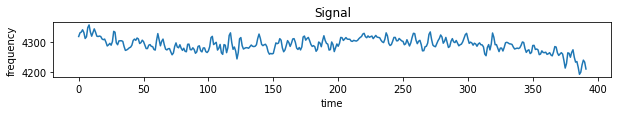

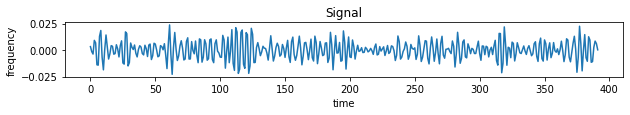

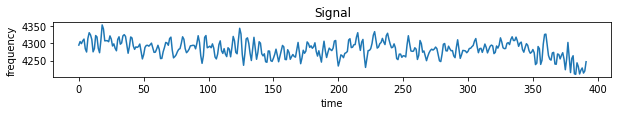

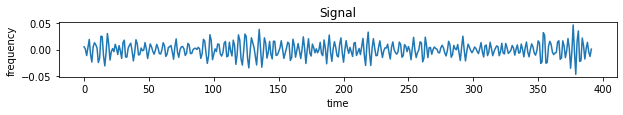

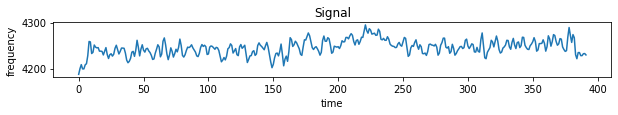

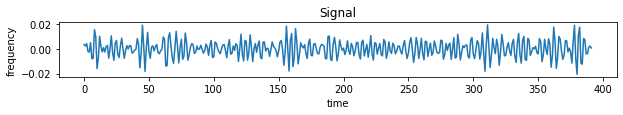

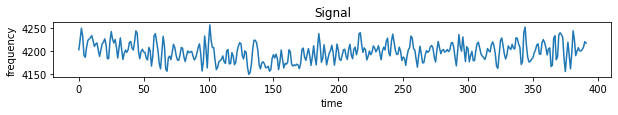

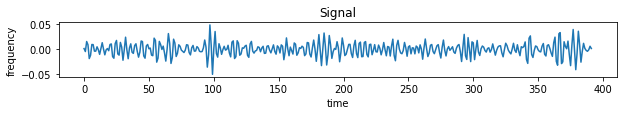

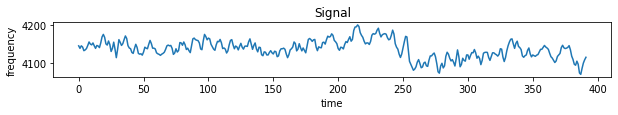

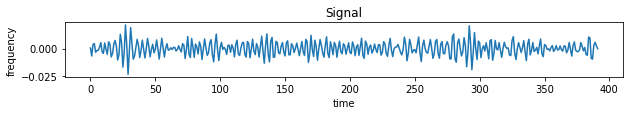

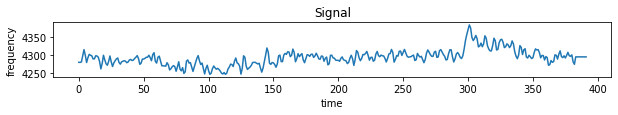

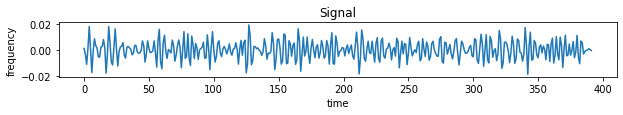

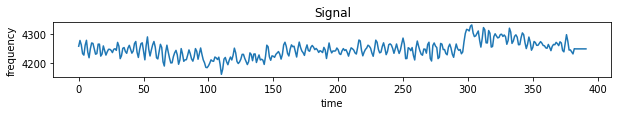

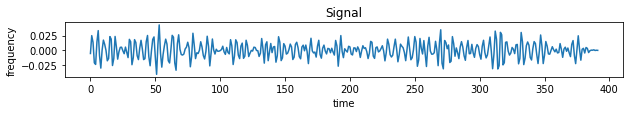

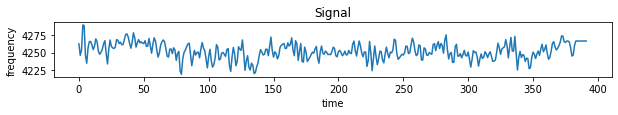

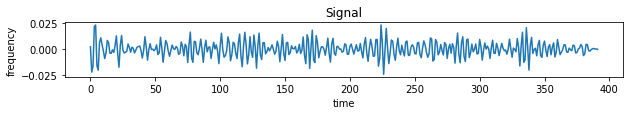

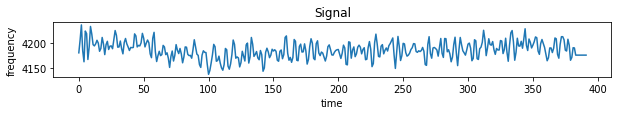

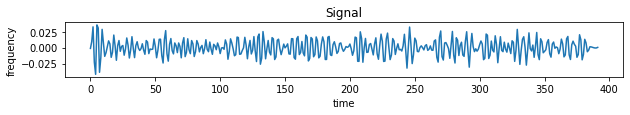

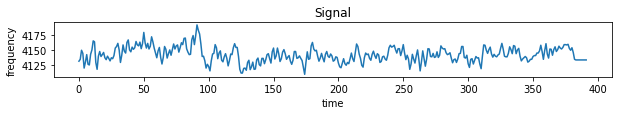

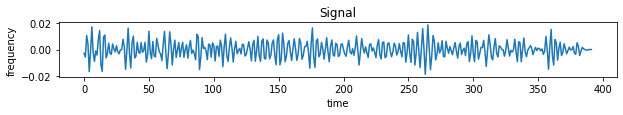

In [21]:
#check sample data (5 signals): before and after filtering
x_sample,y_sample = prepare_data(df_sample,1,unit_test=True) 

In [22]:
len(x_sample)

10

In [23]:
print(x_sample)

[[0.003340646422917158, -0.0013345061191356684, -0.0036715109903271027, 0.00923915340825349, 0.006862109939662969, -0.013778663925186032, -0.014109127177142754, 0.013023838855561133, 0.018533542942043665, -0.006669963762625348, -0.018527992480851723, 0.0004964346916402299, 0.014294237824555385, 0.002565266655282096, -0.008335233600435896, -0.0034574645355653867, 0.004287513871713227, 0.003618153291230783, -0.0037859667990707184, -0.0032389424233621456, 0.005091323871583728, 0.0011894324853074425, -0.006366609328268834, 0.004171917271093093, 0.008780482878335587, -0.012036649483158132, -0.013127778907840892, 0.01721220982907859, 0.015645423332123428, -0.014856552392655565, -0.011720284172884541, 0.006740194526408335, 0.002672854777490551, 0.0005929307123109673, 0.004841005642051678, -0.002865571259577054, -0.006361458238180642, 0.0006928344806655783, 0.004169245591733968, 0.002895639685038931, -0.003193455129641892, -0.004443599175305766, 0.004629811395817686, 0.0014294968772722845, -0.

In [24]:
#get final data for model : X, y
X,y = prepare_data(df_main,1)

X= np.array(X)   #convert X to numpy array

le = LabelEncoder()
y = le.fit_transform(y)                                 #for ML models
yy = tf.keras.utils.to_categorical(le.fit_transform(y)) #for cateorical problems/DNN

# Resampling X, y

In [25]:
orig_shape = X.shape

#take backup copy
X_orig=X.copy()
y_orig=y.copy()

orig_shape  #original shape of X

(70060, 392)

In [26]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import collections, numpy

#function to print count  of classes
def print_counter(y_data):
  counter = Counter(y)
  for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
  #plot the distribution of classes
  plt.bar(counter.keys(), counter.values())
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Class=0, n=38675 (55.203%)
Class=2, n=3190 (4.553%)
Class=5, n=2695 (3.847%)
Class=7, n=5045 (7.201%)
Class=3, n=8565 (12.225%)
Class=8, n=5895 (8.414%)
Class=6, n=2905 (4.146%)
Class=4, n=745 (1.063%)
Class=1, n=2345 (3.347%)


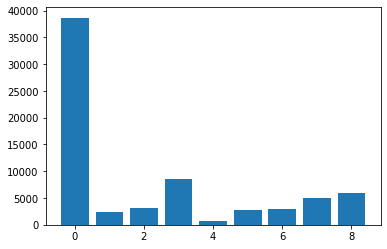

In [27]:
print_counter(y) #original y distribution

In [28]:

count_class=collections.Counter(y)
print(count_class) #occurances of all classes
count_class[0] #number of occurances of class 0

Counter({0: 38675, 3: 8565, 8: 5895, 7: 5045, 2: 3190, 6: 2905, 5: 2695, 1: 2345, 4: 745})


38675

In [29]:
int(count_class[0]*25/100)  #retain 25% of data from 0 with 0 class

9668

### Undersampling majority classes

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class=0, n=9668 (23.550%)
Class=1, n=2345 (5.712%)
Class=2, n=3190 (7.770%)
Class=3, n=8565 (20.863%)
Class=4, n=745 (1.815%)
Class=5, n=2695 (6.565%)
Class=6, n=2905 (7.076%)
Class=7, n=5045 (12.289%)
Class=8, n=5895 (14.359%)


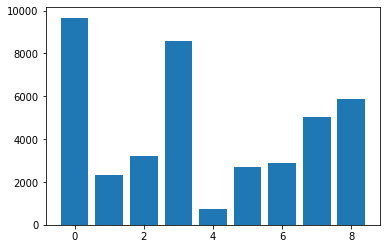

In [30]:
from imblearn.under_sampling import RandomUnderSampler


rus = RandomUnderSampler({0:int(count_class[0]*25/100)},random_state=0)
rus.fit(X, y)
X, y = rus.fit_resample(X, y)


print_counter(y)

### Oversampling minority classes

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class=0, n=9668 (11.111%)
Class=1, n=9668 (11.111%)
Class=2, n=9668 (11.111%)
Class=3, n=9668 (11.111%)
Class=4, n=9668 (11.111%)
Class=5, n=9668 (11.111%)
Class=6, n=9668 (11.111%)
Class=7, n=9668 (11.111%)
Class=8, n=9668 (11.111%)


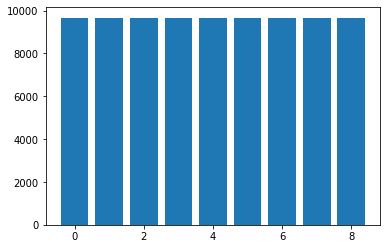

In [31]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
ros.fit(X, y)
X, y = ros.fit_resample(X, y)

print_counter(y)

# After Sampling : X, y

In [32]:
X=X 
y=y
yy = tf.keras.utils.to_categorical(le.fit_transform(y)) #for cateorical problems/DNN

In [33]:
X.shape, y.shape, yy.shape

((87012, 392), (87012,), (87012, 9))

In [34]:
type(X), type(y), type(yy)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [35]:
len(X[1])

392

In [36]:
y[:6]

array([0, 0, 0, 0, 0, 0])

In [37]:
yy[:7]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [38]:
#shuffle data

idx = np.random.permutation(len(X))
X_nn = X[idx]
y_nn = yy[idx]                  #for simple caegorical problem
y_ml = y[idx]                   #for ML models

In [39]:
X_nn.shape, y_nn.shape, y_ml.shape

((87012, 392), (87012, 9), (87012,))

In [40]:
num_labels = len(np.unique(y_ml))
num_labels

9

In [41]:
#plot accuracies
def plot_accuracy(history, plot_type="accuracy"):
  if plot_type=="categorical_accuracy":
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
  else:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
  
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  print("\n")

#plot loss graph
def plot_loss(history):
  plt.plot(history.history['loss']) 
  plt.plot(history.history['val_loss']) 
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Test'], loc='upper left') 
  plt.show()
  print("\n")

# DNN

In [42]:
#y_nn for categorical

X_train, X_test, y_train, y_test = train_test_split(X_nn,y_nn, test_size=0.3, random_state = 2021,shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60908, 392), (26104, 392), (60908, 9), (26104, 9))

In [43]:
def make_model_DNN():

  model = Sequential()

  
  model.add(Dense(512, input_dim= X_train.shape[1], activation='relu'))

  model.add(Dense(512, input_dim= X_train.shape[1], activation='relu'))


  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))


  model.add(Dense(num_labels, activation='softmax'))

  return model

In [44]:
model = make_model_DNN()
#keras.utils.plot_model(model, show_shapes=True)   #visual representation of summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               201216    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6

In [45]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)  #early stopping #overfitting
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.01
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [46]:
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), 
                    verbose=1,callbacks=callbacks)

Epoch 1/500
1904/1904 [==============================] - 28s 14ms/step - loss: 2.1985 - accuracy: 0.1108 - val_loss: 2.1973 - val_accuracy: 0.1110
Epoch 2/500
1904/1904 [==============================] - 27s 14ms/step - loss: 2.1973 - accuracy: 0.1123 - val_loss: 2.1980 - val_accuracy: 0.1117
Epoch 3/500
1904/1904 [==============================] - 26s 14ms/step - loss: 2.1985 - accuracy: 0.1107 - val_loss: 2.1958 - val_accuracy: 0.1124
Epoch 4/500
1904/1904 [==============================] - 29s 15ms/step - loss: 2.1953 - accuracy: 0.1128 - val_loss: 2.1947 - val_accuracy: 0.1127
Epoch 5/500
1904/1904 [==============================] - 26s 14ms/step - loss: 2.1942 - accuracy: 0.1152 - val_loss: 2.1943 - val_accuracy: 0.1144
Epoch 6/500
1904/1904 [==============================] - 26s 14ms/step - loss: 2.1939 - accuracy: 0.1139 - val_loss: 2.1962 - val_accuracy: 0.1114
Epoch 7/500
1904/1904 [==============================] - 26s 14ms/step - loss: 2.1930 - accuracy: 0.1147 - val_loss: 2

In [47]:
#model = keras.models.load_model("best_model.h5")

train_loss, train_acc = model.evaluate(X_train, y_train)

print("Train accuracy", train_acc)
print("Train loss", train_loss)

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

1904/1904 [==============================] - 8s 4ms/step - loss: 0.2149 - accuracy: 0.9260
Train accuracy 0.926019549369812
Train loss 0.21490685641765594
816/816 [==============================] - 3s 4ms/step - loss: 1.5189 - accuracy: 0.7091
Test accuracy 0.7090867161750793
Test loss 1.5188953876495361


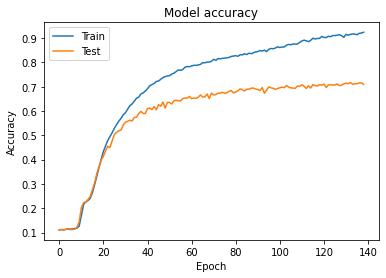

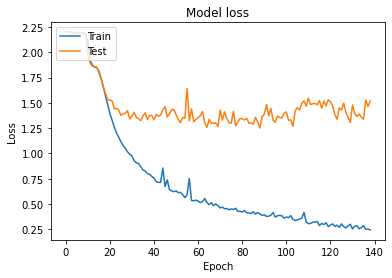

In [48]:
plot_accuracy(history,model.metrics_names[1])
print("\n")
plot_loss(history)